<a href="https://colab.research.google.com/github/darja/NeuralUni/blob/master/06_pretrained_ryazhskikh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Применение предварительно обученных сетей для распознавания котов и собак

## Домашнее задание

1. Примите условия соревнования на сайте Kaggle по ссылке в материалах курса.
2. Отправьте базовое решение.
3. Попытайтесь улучшить решение:
    - Изменяйте часть сети, отвечающей за классификацию: количество нейронов в полносвязном слое (попробуйте варианты 32, 128, 256, 512, 1024) и параметры Dropout (0.25, 0.5, 0.6, 0.8).
    - Добавьте еще один полносвязный слой перед выходным слоем (количество нейронов 32, 128, 256).
    - Изменяйте размер мини-выборки, попробуйте варианты 25, 50, 100, 125.
    - Изменяйте параметр скорости обучения, который задается в аргументе `lr` при компиляции сети (`optimizer=Adam(lr=1e-5)`). Попробуйте значения  1e-3, 1e-4, 1e-5 и 1e-6.
    - Изменяйте количество шагов на каждой эпохе обучения. В примере количество шагов равно числу изображений деленному на размер мини-выборки. Попробуйте уменьшить это количество вдвое, а также увеличить в два или 4 раза.
    - Изменяйте параметры дополнения данных (документация https://keras.io/preprocessing/image/ ).
    - Попробйуте включить тонкую настройку нейронной сети: разморозить несколько слоев VGG16 и дообучить их. Попробуйте два варианта тонкой настройки: разморозка слоев начиная с `block5_conv1` и `block4_conv1`.  
    - Замените сеть VGG16 на Inception, или любую другую из https://keras.io/applications/. [Ноутбук с примером использования сети Inception](https://colab.research.google.com/drive/1xBNk2wGPXzWvaS8EBfE4WPoZpV_gojcS).
4. Составьте описание лучшего варианта сети и подготовьте обоснование, почему именно такую архитектуру вы выбрали.

## Подготовка окружения

In [41]:
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from google.colab import files
from keras.models import Model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import toimage
%matplotlib inline 

!pip install kaggle

### Загрузка токена аутентификации Kaggle

In [2]:
file = files.upload()
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

Saving kaggle.json to kaggle.json


## Подготовка данных

### Загрузка данных с Kaggle

In [4]:
!kaggle competitions download -c nu-cats-and-dogs-spring2019
!unzip -q train.zip
!unzip -q test.zip

 94% 102M/108M [00:00<00:00, 130MB/s] 
100% 108M/108M [00:00<00:00, 139MB/s]
  0% 0.00/10.7k [00:00<?, ?B/s]
100% 10.7k/10.7k [00:00<00:00, 8.99MB/s]
 41% 9.00M/22.1M [00:00<00:00, 81.5MB/s]
100% 22.1M/22.1M [00:00<00:00, 103MB/s] 


In [4]:
!ls

sample_data  sample_submission.csv  test  test.zip  train  train.zip


### Подготовка папки для валидации

In [0]:
!mkdir val
!mkdir val/cats
!mkdir val/dogs

!mv train/cats/cat.{0..499}.jpg val/cats
!mv train/dogs/dog.{0..499}.jpg val/dogs

In [0]:
# !mv val/cats/cat.500.jpg train/cats
!mv val/cats/dog.{0..499}.jpg val/dogs
!mv val/cats/dog.500.jpg train/dogs

### Пример картинки

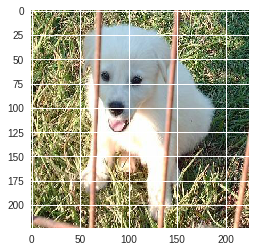

In [6]:
img_path = 'test/3.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()

### Генератор изображений

In [47]:
train_dir = 'train'
val_dir = "val"
img_width, img_height = 224, 224
batch_size = 100
nb_train_samples = 4000
input_shape = (img_width, img_height, 3)

# Training generator
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                  rotation_range=20,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

print("Train classes", train_generator.class_indices)

# Validation generator
val_datagen = ImageDataGenerator(rescale=1. / 255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary"
)
print("Val classes", train_generator.class_indices)

Found 4000 images belonging to 2 classes.
Train classes {'cats': 0, 'dogs': 1}
Found 1000 images belonging to 2 classes.
Val classes {'cats': 0, 'dogs': 1}


#### Демонстрация работы генератора

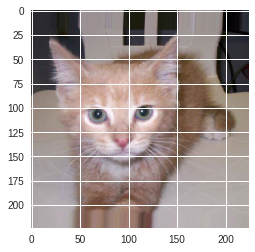

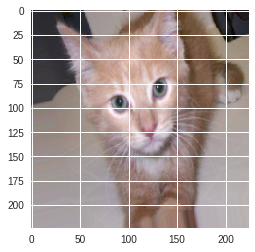

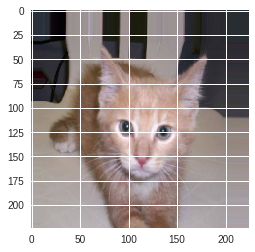

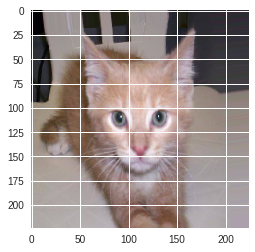

In [15]:
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

## Подготовка нейронной сети

### Создание нейронной сети

In [0]:
def create_vgg16():
  print("\n---- VGG 16 ----\n")
  base = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)
  base.trainable = False
#   base.summary()
  return base

def create_inception():
  print("\n---- Inception ----\n")
  base = InceptionV3(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)
  for layer in base.layers:
      layer.trainable = False
  return base

def createNasNetLarge():
  base = NASNetLarge(input_shape=input_shape, include_top=False, weights='imagenet', input_tensor=None, pooling=None, classes=1000)
  base.trainable = False
  return base

#### Сеть на основе Inception V3

In [23]:
# # load base pre-trained model
base_model = create_inception()

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

predictions = Dense(1, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])


---- Inception ----



#### Сеть на основе VGG16

In [52]:
base = create_vgg16()
base.summary()

model = Sequential()
model.add(base)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])



---- VGG 16 ----

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0 

### Обучение нейронной сети

In [53]:
# model.summary()

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator, 
    validation_steps = val_generator.samples // batch_size,
    epochs=18,
    verbose=1)

Epoch 1/18
40/40 [==============================] - 70s 2s/step - loss: 0.5506 - acc: 0.7132 - val_loss: 0.3638 - val_acc: 0.8660
Epoch 2/18
40/40 [==============================] - 77s 2s/step - loss: 0.3882 - acc: 0.8380 - val_loss: 0.2859 - val_acc: 0.8940
Epoch 3/18
40/40 [==============================] - 78s 2s/step - loss: 0.3255 - acc: 0.8710 - val_loss: 0.2473 - val_acc: 0.9070
Epoch 4/18
40/40 [==============================] - 78s 2s/step - loss: 0.3005 - acc: 0.8790 - val_loss: 0.2419 - val_acc: 0.9000
Epoch 5/18
40/40 [==============================] - 79s 2s/step - loss: 0.2779 - acc: 0.8857 - val_loss: 0.2188 - val_acc: 0.9070
Epoch 6/18
40/40 [==============================] - 78s 2s/step - loss: 0.2604 - acc: 0.8932 - val_loss: 0.2128 - val_acc: 0.9130
Epoch 7/18
40/40 [==============================] - 78s 2s/step - loss: 0.2528 - acc: 0.8960 - val_loss: 0.1944 - val_acc: 0.9160
Epoch 8/18
40/40 [==============================] - 78s 2s/step - loss: 0.2357 - acc: 0.90

### Визуализация обучения

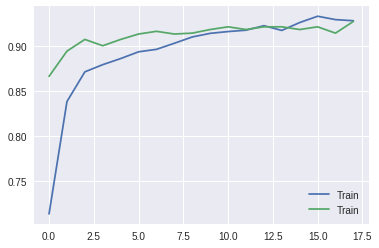

In [54]:
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Validation')
plt.legend()
plt.show()

### Дообучение по необходимости

Epoch 1/5
50/50 [==============================] - 87s 2s/step - loss: 0.2416 - acc: 0.9038
Epoch 2/5
50/50 [==============================] - 94s 2s/step - loss: 0.2383 - acc: 0.9010
Epoch 3/5
50/50 [==============================] - 96s 2s/step - loss: 0.2348 - acc: 0.9000
Epoch 4/5
50/50 [==============================] - 95s 2s/step - loss: 0.2209 - acc: 0.9102
Epoch 5/5
50/50 [==============================] - 95s 2s/step - loss: 0.2287 - acc: 0.9042


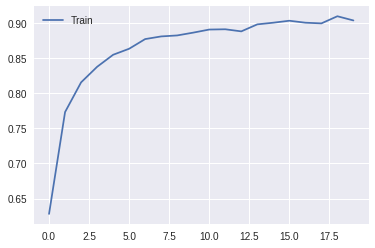

In [83]:
history1 = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=5,
    verbose=1)

acc = []
acc.extend(history.history['acc'])
acc.extend(history1.history['acc'])

plt.plot(acc, label='Train')
plt.legend()
plt.show()

## Распознавание картинок

In [0]:
to_binary = np.vectorize(lambda x: 0 if x < 0.5 else 1)
flatten = lambda l: [item for sublist in l for item in sublist]


### Проверка на тренировочной выборке

In [62]:
!mkdir test_train
!cp -r train test_train
!mv test_train/train test_train/test

!mkdir test_val
!cp -r val test_val
!mv test_val/val test_val/test


mkdir: cannot create directory ‘test_val’: File exists


In [0]:
def evaluate_folder(folder):
  datagen = ImageDataGenerator(rescale=1./255)
  generator = datagen.flow_from_directory(
    folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary')
  generator.reset()
  print("Train classes", generator.class_indices)
  return model.evaluate_generator(
      generator, 
      steps = generator.samples // batch_size,
      verbose = 1)

def predict_folder(folder):
  datagen = ImageDataGenerator(rescale=1./255)
  generator = datagen.flow_from_directory(
    folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary')
  generator.reset()
  predictions = model.predict_generator(
      generator, 
      steps = generator.samples // batch_size,
      verbose = 1)

  filenames = generator.filenames
  binary_predictions = flatten(to_binary(predictions))

  is_correct = lambda filename, cl: "cat" in filename and cl == 0 or "dog" in filename and cl == 1
  correct_predictictions = list(map(is_correct, filenames, binary_predictions))

  correct_count = sum(correct_predictictions)
  print("[%s] Correct: %s of %s" % (folder, correct_count, len(binary_predictions)))

  return correct_count / len(binary_predictions)


In [161]:
print("---- Test ----\n")
train_eval = evaluate_folder("train")
# # print("Evaluate: ", train_eval)
# train_acc = predict_folder("test_train")
# print("Predict: ", train_acc)

print("\n---- Validation ----\n")
val_eval = evaluate_folder("val")
print("Evaluate: ", val_eval)
# val_acc = predict_folder("test_val")
# print("Predict: ", val_acc)


---- Test ----

Found 4000 images belonging to 2 classes.
Train classes {'cats': 0, 'dogs': 1}
40/40 [==============================] - 38s 948ms/step - loss: 0.1187 - acc: 0.9625

---- Validation ----

Found 1000 images belonging to 2 classes.
Train classes {'cats': 0, 'dogs': 1}
10/10 [==============================] - 10s 960ms/step - loss: 0.1631 - acc: 0.9270
Evaluate:  [0.1631029576063156, 0.927]


## Подготовка решения

### Подготовка окружения

In [0]:
test_dir = 'predict'
nb_test_samples = 1000

!mkdir predict
!mv test predict

In [0]:
to_binary = np.vectorize(lambda x: 1 if x > 0.5 else 0)

### Распознавание картинок

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary')
test_generator.reset()
predictions = model.predict_generator(test_generator, steps = nb_test_samples // batch_size)
binary_predictios = to_binary(predictions)

get_filename = np.vectorize(lambda x: filename.replace('test/',''))
filenames = get_filename(test_generator.filenames)

 out = np.column_stack((filenames, binary_predictions))

np.savetxt('submission.csv', out, header="filename,label", 
            comments="", fmt="%s,%s")

In [40]:
filenames

In [31]:
!head submission.csv

filename,label
<map object at 0x7f25cab9c860>,<numpy.lib.function_base.vectorize object at 0x7f25cabbe358>


### Отправка решения

In [0]:
!kaggle competitions submit -c nu-cats-and-dogs-spring2019 -m "" -f submission.csv